In [1]:
import turicreate as gl
import pandas as pd
import numpy as np
import csv
import math
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline  
import scipy
import random
import dask.dataframe as dd
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# Single-cell RNA-seq analysis
**In this problem, we analyze single-cell RNA-seq data and determine structure in this high-dimensional data. The data set consists of 272 cells, each row corresponds to the RNA-seq measurements of a particular gene. Each entry corresponds to the normalized transcript compatibility count (TCC) of an equivalence class. An equivalence class is a set of short RNA sequences. The TCC counts the number of reads of sequences which are compatible with each equivalence class for a given cell. The entries have been normalized so that each row in the matrix sums to 1.**

In [2]:
filename = "Trapnell.csv"
# Trapnell = pd.read_csv(filename, nrows = 20).T
# Trapnell = np.genfromtxt(filename,delimiter=',',dtype=float)
with open(filename,'r') as dest_f:
    data_iter = csv.reader(dest_f,
                           delimiter = ",")
    data = [data for data in data_iter]
Trapnell = np.asarray(data, dtype = float)

### (a) Determine cell clusters by applying k-means clustering to the data. 

#### 1. Using PCA to reduce demensions from 1,065,024 to 2

In [3]:
pca = decomposition.PCA(n_components=2)
Trapnell_pca = pca.fit_transform(Trapnell)

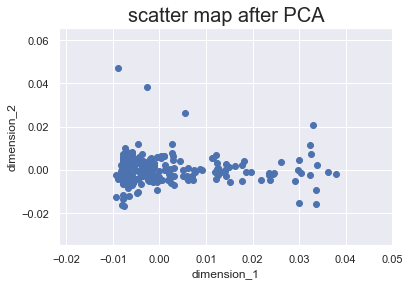

In [55]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
sns.set()
_ = plt.scatter(Trapnell_pca[:,0], Trapnell_pca[:,1])
_ = plt.xlabel("dimension_1")
_ = plt.ylabel("dimension_2")
_ = plt.title("scatter map after PCA", size =20)
plt.show()

#### 2. Determine which number of clusters is the best

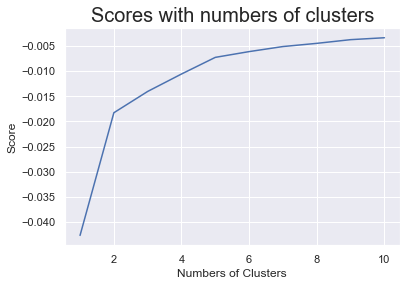

In [56]:
Nc = range(1,11)
kmeans_list = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans_list[i].fit(Trapnell_pca).score(Trapnell_pca) for i in range(len(kmeans_list))]
_ = plt.plot(Nc,score)
_ = plt.xlabel("Numbers of Clusters")
_ = plt.ylabel("Score")
_ = plt.title("Scores with numbers of clusters", size = 20)
plt.show() 

#### 3. Clustering the cells and plot it by color

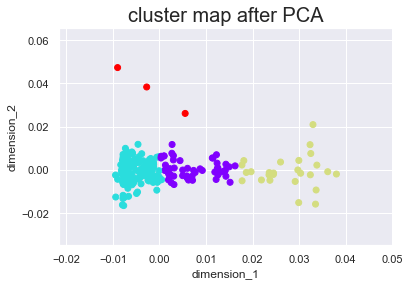

In [57]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(Trapnell_pca)
_ = plt.scatter(Trapnell_pca[:,0],Trapnell_pca[:,1], c=kmeans.labels_, cmap='rainbow') 
_ = plt.xlabel("dimension_1")
_ = plt.ylabel("dimension_2")
_ = plt.title("cluster map after PCA", size =20)
plt.show()

### (b) Which genes are good markers for each cluster? 
#### Using Logistic Regression to determine the good markers

In [7]:
Trapnell_df = pd.DataFrame(Trapnell);
Tarpnell_sf  = gl.SFrame(data=Trapnell)

In [61]:
Trapnell_label = kmeans.labels_

In [62]:
from sklearn.linear_model import LogisticRegression
#Trapnell_sf = gl.SFrame(data=Trapnell_df)
logreg = LogisticRegression(penalty="l2")
logreg.fit(Trapnell_df,Trapnell_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [63]:
cluster_0_largest_feature = np.argmax(logreg.coef_[0])
cluster_1_largest_feature = np.argmax(logreg.coef_[1])
cluster_2_largest_feature = np.argmax(logreg.coef_[2])
cluster_3_largest_feature = np.argmax(logreg.coef_[3])
print "cluster0 good maker gene's position:",cluster_0_largest_feature, "\t coef value:", max(logreg.coef_[0])
print "cluster1 good maker gene's position:",cluster_1_largest_feature, "\t coef value:", max(logreg.coef_[1])
print "cluster2 good maker gene's position:",cluster_2_largest_feature, "\t coef value:", max(logreg.coef_[2])
print "cluster3 good maker gene's position:",cluster_3_largest_feature, "\t coef value:", max(logreg.coef_[3])

cluster0 good maker gene's position: 13895 	 coef value: 0.294141443435
cluster1 good maker gene's position: 94839 	 coef value: 0.168223717667
cluster2 good maker gene's position: 13895 	 coef value: 0.626170928448
cluster3 good maker gene's position: 668 	 coef value: 0.0395964722591


### c) Map the cells to a differentiation tree. 

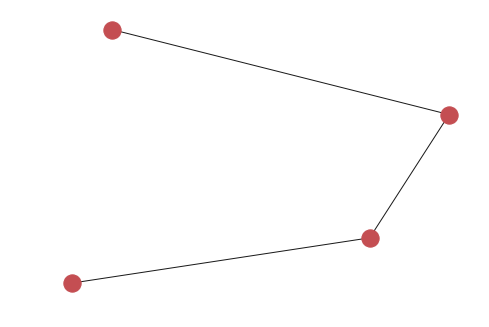

In [47]:
import networkx as nx
centers = kmeans.cluster_centers_
distance = scipy.spatial.distance.cdist(centers,centers)
G = nx.from_numpy_matrix(distance)
T = nx.minimum_spanning_tree(G)
nx.draw(T)